# MQ-3 

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  200kOhm
    Rh (Heater Resistance)     :  33 ohm +/- 5%
    Ph (Heating consumption)   :  less than 750mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 1MOhm  -  8MOhm (0.4mg/L alcohol)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration  Scope:
        Alcohol                :  0.05mg/L  - 10 mg/L


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet

POINTS = {
    'alcohol' : {
        'p1': {'x': 0.100,  'y': 2.332},
        'p2': {'x': 0.216,  'y': 1.539},
        'p3': {'x': 0.402,  'y': 1.025},
        'p4': {'x': 1.008,  'y': 0.542},
        'p5': {'x': 1.646,  'y': 0.396},
        'p6': {'x': 2.535,  'y': 0.289},
        'p7': {'x': 3.998,  'y': 0.206},
        'p8': {'x': 6.044,  'y': 0.163},
        'p9': {'x': 8.090,  'y': 0.131}, 
        'p10':{'x': 10.000, 'y': 0.114}, 
    },
    'benzine' : {
        'p1': {'x': 0.100,  'y': 4.133},
        'p2': {'x': 0.214,  'y': 3.192},
        'p3': {'x': 0.409,  'y': 2.581},
        'p4': {'x': 1.030,  'y': 1.767},
        'p5': {'x': 1.650,  'y': 1.469},
        'p6': {'x': 2.535,  'y': 1.222},
        'p7': {'x': 4.084,  'y': 1.025},
        'p8': {'x': 6.207,  'y': 0.917},
        'p9': {'x': 8.047,  'y': 0.821}, 
        'p10':{'x': 10.000, 'y': 0.784}, 
    },
    # Methane
    'ch4' : {
        'p1': {'x': 0.100,  'y': 49.566},
        'p2': {'x': 0.217,  'y': 48.659},
        'p3': {'x': 0.412,  'y': 46.464},
        'p4': {'x': 1.035,  'y': 44.778},
        'p5': {'x': 1.650,  'y': 42.365},
        'p6': {'x': 2.535,  'y': 42.758},
        'p7': {'x': 4.105,  'y': 41.590},
        'p8': {'x': 6.207,  'y': 40.453},
        'p9': {'x': 8.090,  'y': 40.453}, 
        'p10':{'x': 10.000, 'y': 39.713}, 
    },
    'hexane' : {
        'p1': {'x': 0.100,  'y': 51.432},
        'p2': {'x': 0.217,  'y': 39.713},
        'p3': {'x': 0.414,  'y': 30.949},
        'p4': {'x': 1.041,  'y': 22.609},
        'p5': {'x': 6.207,  'y': 12.520},
        'p6': {'x': 8.090,  'y': 11.001},
        'p7': {'x': 10.000, 'y': 10.031},
    },
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 0.100,  'y': 51.432},
        'p2': {'x': 0.216,  'y': 43.959},
        'p3': {'x': 0.414,  'y': 36.210},
        'p4': {'x': 1.041,  'y': 29.826},
        'p5': {'x': 6.240,  'y': 16.065},
        'p6': {'x': 8.047,  'y': 13.987},
        'p7': {'x': 10.000, 'y': 13.111},
    },
    # Carbon Monoxide
    'co' : {
        'p1': {'x': 0.100,  'y': 51.909},
        'p2': {'x': 0.216,  'y': 45.613},
        'p3': {'x': 0.414,  'y': 41.975},
        'p4': {'x': 1.035,  'y': 33.943},
        'p5': {'x': 6.174,  'y': 20.237},
        'p6': {'x': 8.026,  'y': 18.198},
        'p7': {'x': 10.000, 'y': 16.214},
    }  
}


AIR = 60

GASES = ['alcohol', 'benzine', 'ch4', 'hexane', 'lpg', 'co']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# mg/L value calculation 
MgL   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

# PPM value calculation 
PPM   = lambda y, m, b: MgL(y, m, b) * 1000

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq3_1", "mq3_2"]
df = pd.read_csv('EmptyRoom_9-14Jun.csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq3_1 = df[["date","mq3_1"]]
mq3_2 = df[["date","mq3_2"]]

### Ro values to be considered

- __Sensor 1__: 1.500 kOhms
- __Sensor 2__: 1.569 kOhms

In [7]:
### MQ 3 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 1.569  #kOhms 

# MQ 3 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 1.500  #kOhms 

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq3_1['mq3_1'].min(),
    mq3_1['mq3_1'].mean(), 
    mq3_1['mq3_1'].quantile(0.25),
    mq3_1['mq3_1'].quantile(0.5),
    mq3_1['mq3_1'].quantile(0.75),
    mq3_1['mq3_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq3_2['mq3_2'].min(),
    mq3_2['mq3_2'].mean(), 
    mq3_2['mq3_2'].quantile(0.25),
    mq3_2['mq3_2'].quantile(0.5),
    mq3_2['mq3_2'].quantile(0.75),
    mq3_2['mq3_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))
    

In [10]:
print(f"Period in which the readings were carried out:\
{mq3_1['date'].min()} - {mq3_1['date'].max()} \n")


print("Sensor 1")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
    
print("-"*(12*7))

print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))


Period in which the readings were carried out:2022-06-09 20:27:00 - 2022-06-14 09:08:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        57.361       40.134       46.739       39.151       34.482       31.118      
ALCOHOL      0.265        0.513        0.387        0.537        0.68         0.822       
BENZINE      0.043        0.124        0.079        0.133        0.194        0.262       
CH4          0.218        8859.106     379.589      11776.324    50604.77     164472.733  
HEXANE       72.115       210.247      133.199      225.156      312.874      408.213     
LPG          58.556       293.144      159.893      318.571      522.331      850.987     
CO           55.163       502.366      186.802      559.081      966.966      1397.275    
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           M

In [11]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

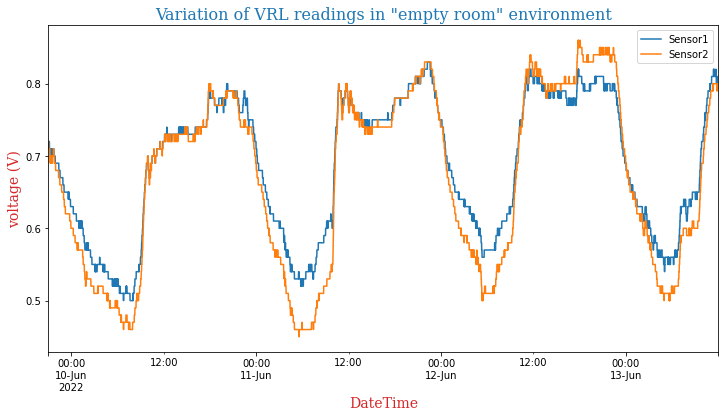

In [12]:
fdf = df[(df['date'] > '6/9/22 9:00 PM') & (df['date'] < '6/13/22 12:00 PM')]

ax = fdf.plot(x='date', y=["mq3_1","mq3_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 3 Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq3_1["mq3_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq3_1[gas] = ppm1[gas]

In [14]:
# MQ 3 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq3_2["mq3_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq3_2[gas] = ppm2[gas]

In [15]:
mq3_1.describe()

,mq3_1,alcohol,benzine,ch4,hexane,lpg,co
count,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000
mean,0.685207,0.527053,0.134428,26084.413644,220.425582,337.204150,573.688751
std,0.096285,0.153194,0.059336,31315.815509,92.935526,194.580741,387.800779
min,0.500000,0.264627,0.043251,0.218242,72.115434,58.555622,55.162873
25%,0.600000,0.386762,0.079052,379.589175,133.199036,159.892823,186.801587
50%,0.700000,0.537032,0.133186,11776.324356,225.156254,318.570778,559.080605
75%,0.780000,0.679515,0.193585,50604.770179,312.874194,522.331298,966.966250
max,0.850000,0.821909,0.261924,164472.732590,408.213370,850.986919,1397.274893


In [16]:
mq3_2.describe()

,mq3_2,alcohol,benzine,ch4,hexane,lpg,co
count,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000,6522.000000
mean,0.666398,0.464703,0.112589,17468.000776,185.732263,267.048017,453.801728
std,0.120933,0.170745,0.061499,23643.315706,98.853076,189.800367,374.387842
min,0.450000,0.196227,0.026891,0.000251,44.467239,26.532809,21.096088
25%,0.550000,0.296575,0.051840,2.880994,86.708863,79.177109,79.570608
50%,0.690000,0.479025,0.111063,4015.837597,188.247073,259.018169,428.450361
75%,0.780000,0.625182,0.169572,30196.528268,278.463521,421.785290,796.431710
max,0.860000,0.776220,0.239167,115399.522225,376.842570,734.848260,1256.007902


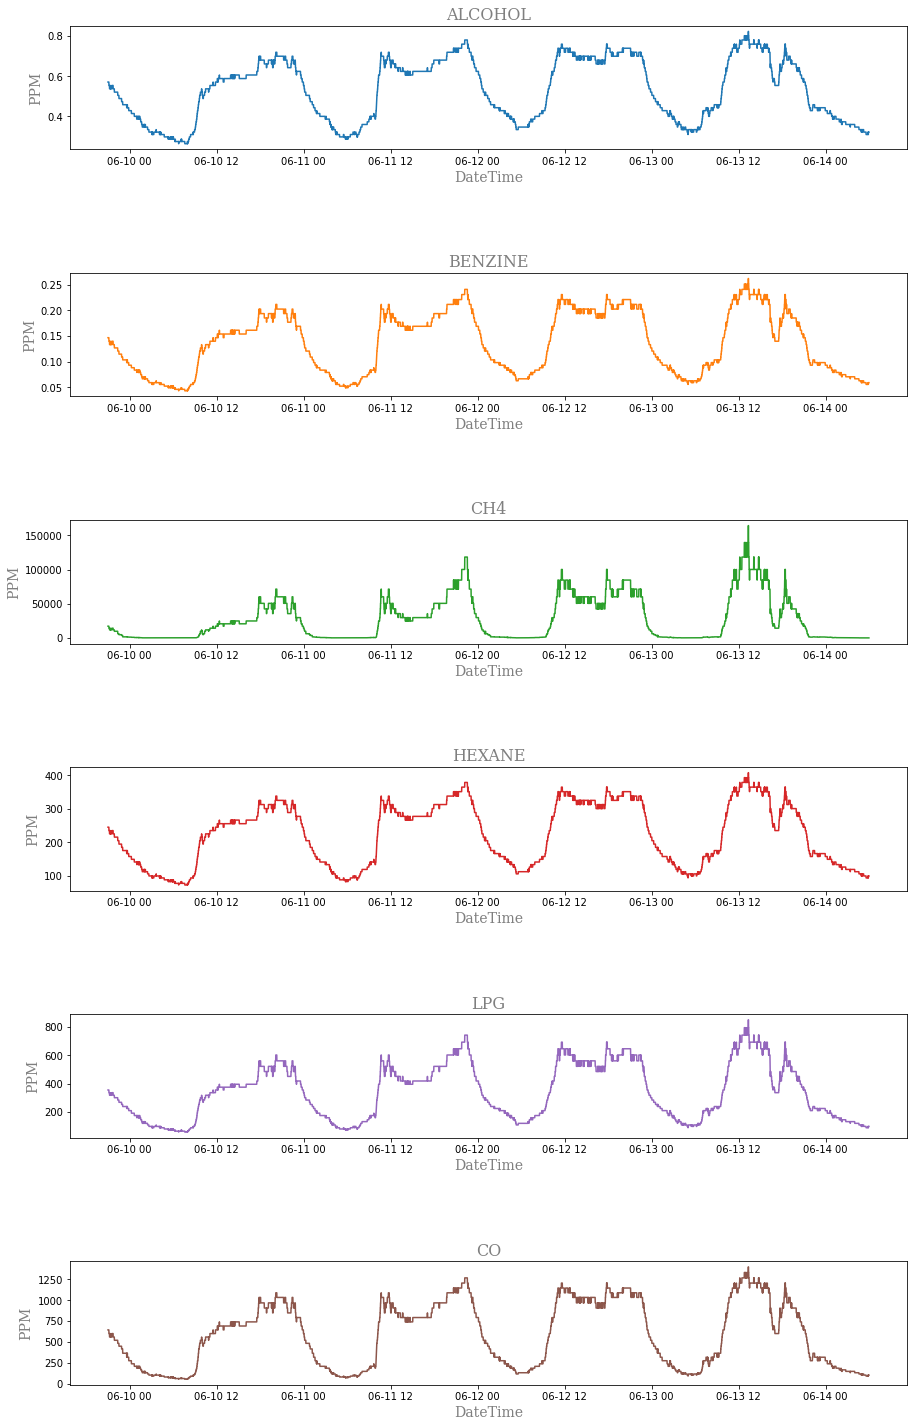

In [17]:
# Time Interval:
#           min: 2022-06-09 20:27:00
#           max: 2022-06-14 09:08:00 

fmq = mq3_1[(mq3_1['date'] > '6/9/22 9:00 PM') & (mq3_1['date'] < '6/14/22 06:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


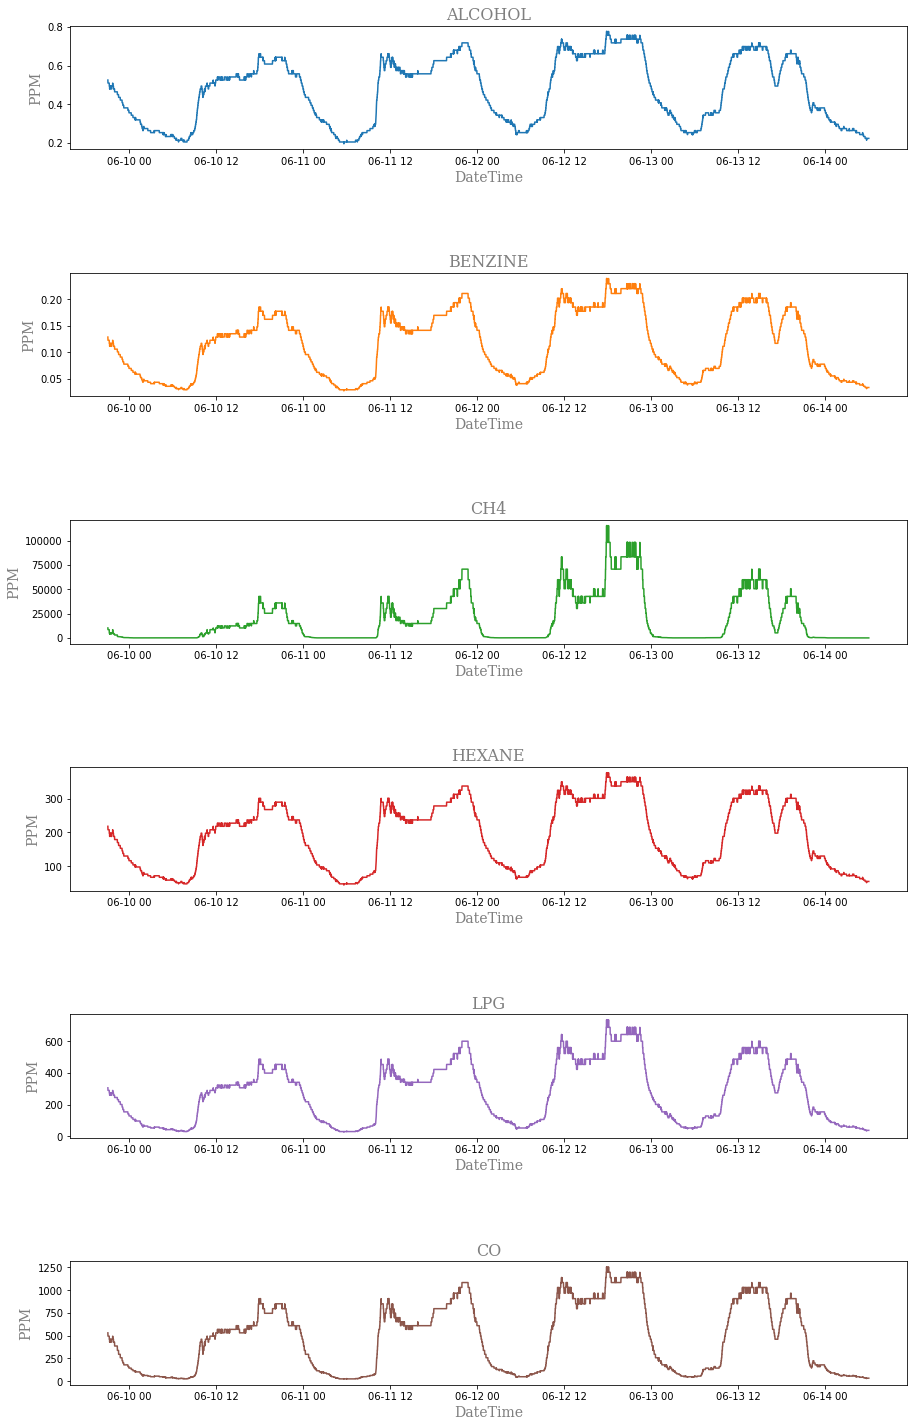

In [18]:
# Time Interval:
#           min: 2022-06-09 20:27:00
#           max: 2022-06-14 09:08:00 

fmq = mq3_2[(mq3_2['date'] > '6/9/22 9:00 PM') & (mq3_2['date'] < '6/14/22 06:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


In [19]:
# Save in excel file
mq3_1.to_csv('mq3_1_in_empty_room.csv')
mq3_2.to_csv('mq3_2_in_empty_room.csv')